In [3]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
  Using cached transformers-4.39.3-py3-none-any.whl.metadata (134 kB)
Using cached transformers-4.39.3-py3-none-any.whl (8.8 MB)


In [12]:
!pip install matplotlib os torch cv2 numpy keras_ocr pyterrseract tensorflow string

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [4]:
import cv2
import pytesseract
import string
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer, AutoModelForSequenceClassification
import torch
from PIL import Image
import os

pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

In [5]:
def preprocess_image(image):
    image = cv2.bilateralFilter(image, 5, 55, 60)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, image = cv2.threshold(image, 240, 255, cv2.THRESH_BINARY)
    return image

In [6]:
def extract_text_from_image(image_path):
    image = cv2.imread(image_path)
    image = preprocess_image(image)
    text = pytesseract.image_to_string(image)
    allowed_chars = string.ascii_letters + string.digits + " "
    filtered_text = "".join(char if char in allowed_chars else " " for char in text).replace("\n", " ")
    return filtered_text

In [7]:
def generate_image_caption(image_path):
    model_name = "bipin/image-caption-generator"
    model = VisionEncoderDecoderModel.from_pretrained(model_name)
    feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained("gpt2")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert(mode="RGB")

    pixel_values = feature_extractor(images=[img], return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)

    max_length = 128
    num_beams = 4

    # get model prediction
    output_ids = model.generate(pixel_values, num_beams=num_beams, max_length=max_length)

    # decode the generated prediction
    preds = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return preds

In [8]:
def detect_hate_speech(text):
    tokenizer = AutoTokenizer.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")
    model = AutoModelForSequenceClassification.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")
    
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    hate_confidence = predictions[0][1].item()  # Assuming the second index corresponds to "hateful"
    classification = "hateful" if hate_confidence > 0.5 else "not hateful"
    confidence = hate_confidence if classification == "hateful" else 1 - hate_confidence
    return classification, confidence

In [9]:
def analyze_meme_for_toxicity(image_path, output_file):
    extracted_text = extract_text_from_image(image_path)
    image_caption = generate_image_caption(image_path)
    combined_text = extracted_text + " " + image_caption
    
    # Analyze individually and combined
    results = {}
    results["extracted_text"] = detect_hate_speech(extracted_text)
    results["image_caption"] = detect_hate_speech(image_caption)
    results["combined_text"] = detect_hate_speech(combined_text)
    
    # Write results to file
    with open(output_file, "a") as file:
        file.write(f"Image File Name: {os.path.basename(image_path)}\n")
        for text_type, (classification, confidence) in results.items():
            file.write(f"{text_type.capitalize()} - Classification: {classification}, Confidence: {confidence:.4f}\n")
        file.write("\n")

In [10]:
def analyze_folder_for_toxicity(folder_path):
    output_file = "detection_results.txt"
    # Ensure the output file is empty before starting
    open(output_file, 'w').close()
    
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            analyze_meme_for_toxicity(image_path, output_file)

In [14]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Update this path if it's different

In [16]:
folder_path = 'C:/Users/sudee/OneDrive/Desktop/projectmeme/img' #Enter the path of the folder containing images you wish to use
analyze_folder_for_toxicity(folder_path)

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

C:\Users\sudee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

C:\Users\sudee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sudee\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

C:\Users\sudee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sudee\.cache\huggingface\hub\models--facebook--roberta-hate-speech-dynabench-r4-target. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(mess

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

C:\Users\sudee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


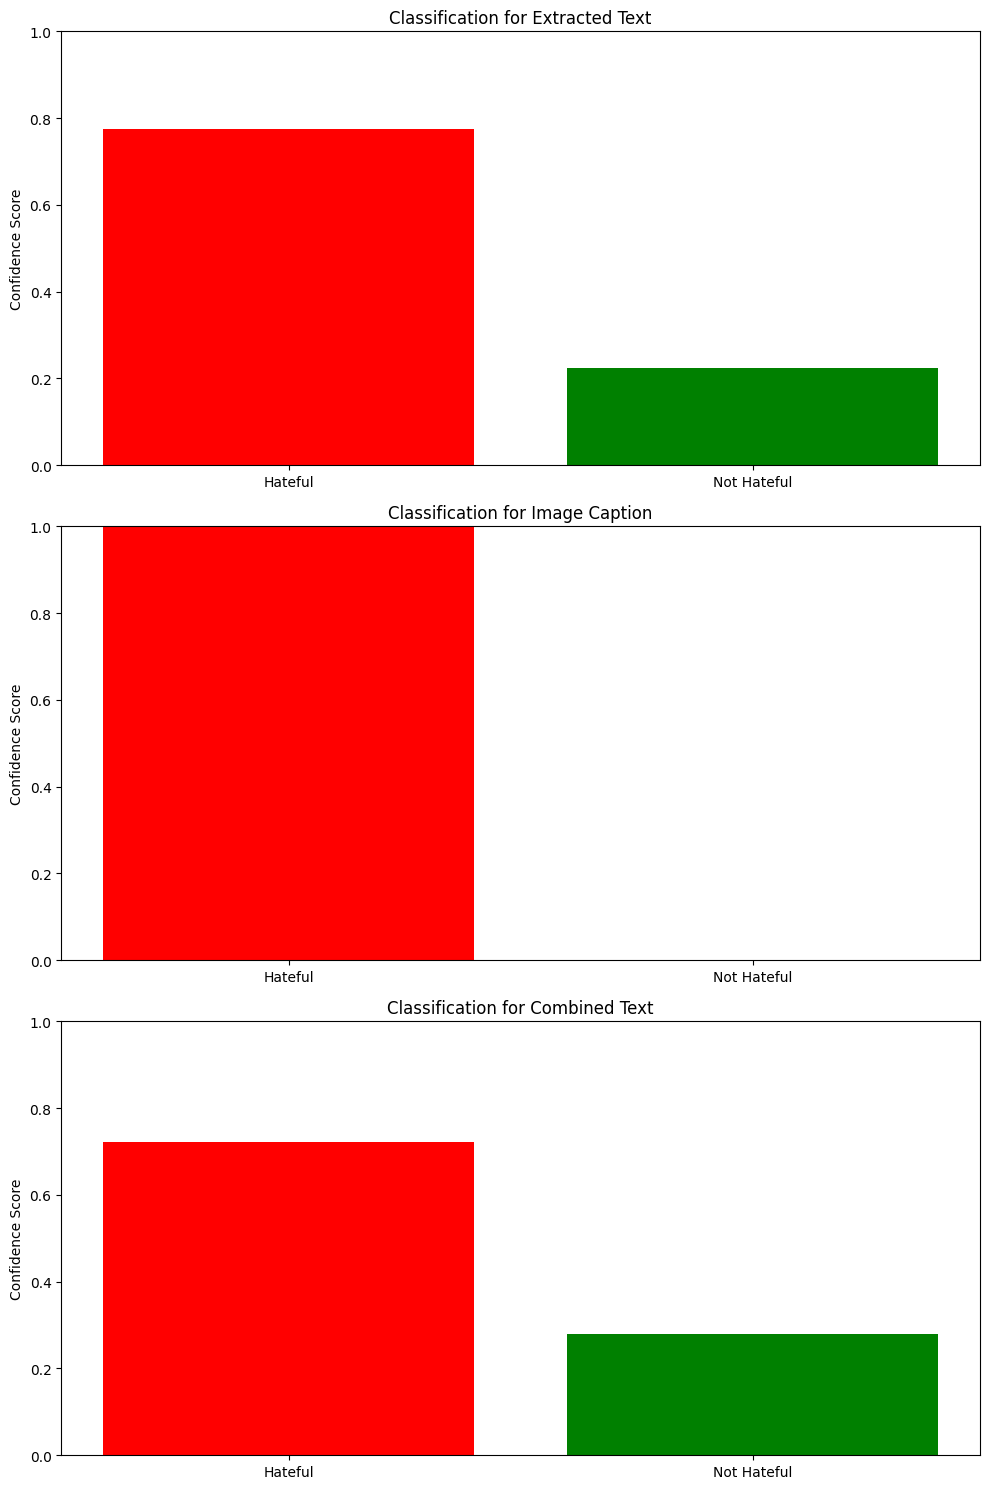

In [2]:
import matplotlib.pyplot as plt

# Data for bar chart
categories = ['Extracted Text', 'Image Caption', 'Combined Text']
classifications = ['Hateful', 'Not Hateful']
confidence_scores = [[0.7749, 0.2251], [0.9994, 0.0006], [0.7213, 0.2787]]

# Plotting
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

for i in range(3):
    ax[i].bar(classifications, confidence_scores[i], color=['red', 'green'])
    ax[i].set_title(f'Classification for {categories[i]}')
    ax[i].set_ylabel('Confidence Score')
    ax[i].set_ylim([0, 1])

plt.tight_layout()
plt.show()


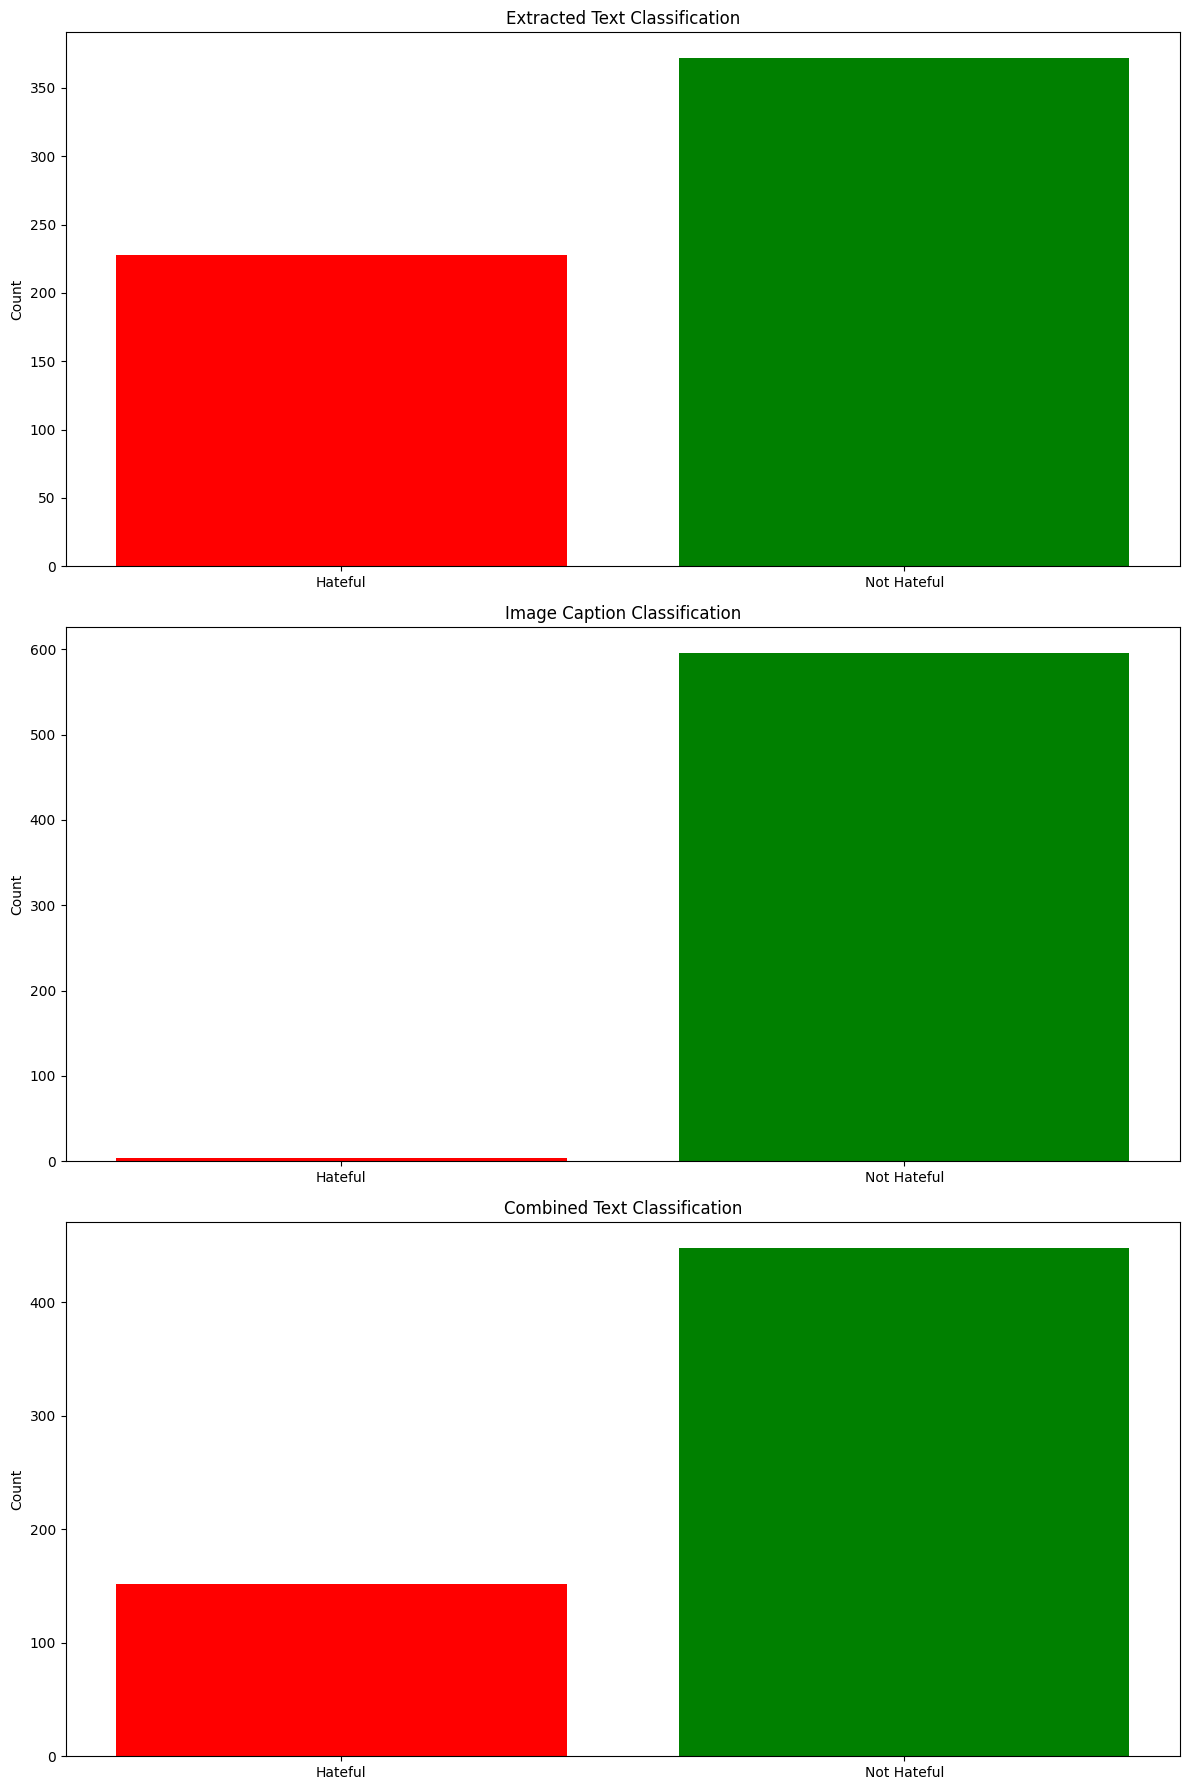

In [14]:
import matplotlib.pyplot as plt

# Path to the detection results file
file_path = 'C:/Users/sudee/OneDrive/Desktop/aa/Analyzing-Hateful-Memes/Bonus Task/detection_results.txt'

# Initialize a dictionary to store classification results for each category
classification_results = {'Extracted Text': [], 'Image Caption': [], 'Combined Text': []}

# Read the detection results file
with open(file_path, 'r') as file:
    lines = file.readlines()
    for i in range(1, len(lines), 5):  # Start from index 1 and step by 5
        if i + 4 > len(lines):  # Check if there are enough lines remaining
            break

        extracted_text_line, image_caption_line, combined_text_line = lines[i:i+3]

        # Check if extracted_text_line is not empty and contains ': '
        if extracted_text_line.strip() and ': ' in extracted_text_line:
            extracted_text_split = extracted_text_line.strip().split(': ')
            if len(extracted_text_split) > 1:
                extracted_text_class = extracted_text_split[1].split(',')[0]
            else:
                extracted_text_class = 'unknown'
        else:
            extracted_text_class = 'unknown'

        # Check if image_caption_line is not empty and contains ': '
        if image_caption_line.strip() and ': ' in image_caption_line:
            image_caption_split = image_caption_line.strip().split(': ')
            if len(image_caption_split) > 1:
                image_caption_class = image_caption_split[1].split(',')[0]
            else:
                image_caption_class = 'unknown'
        else:
            image_caption_class = 'unknown'

        # Check if combined_text_line is not empty and contains ': '
        if combined_text_line.strip() and ': ' in combined_text_line:
            combined_text_split = combined_text_line.strip().split(': ')
            if len(combined_text_split) > 1:
                combined_text_class = combined_text_split[1].split(',')[0]
            else:
                combined_text_class = 'unknown'
        else:
            combined_text_class = 'unknown'

        classification_results['Extracted Text'].append(extracted_text_class)
        classification_results['Image Caption'].append(image_caption_class)
        classification_results['Combined Text'].append(combined_text_class)

# Plotting
fig, ax = plt.subplots(3, 1, figsize=(12, 18))

def plot_classification(ax, classifications, title):
    counts = [classifications.count('hateful'), classifications.count('not hateful')]
    ax.bar(['Hateful', 'Not Hateful'], counts, color=['red', 'green'])
    ax.set_title(title)
    ax.set_ylabel('Count')

plot_classification(ax[0], classification_results['Extracted Text'], 'Extracted Text Classification')
plot_classification(ax[1], classification_results['Image Caption'], 'Image Caption Classification')
plot_classification(ax[2], classification_results['Combined Text'], 'Combined Text Classification')

plt.tight_layout()
plt.show()


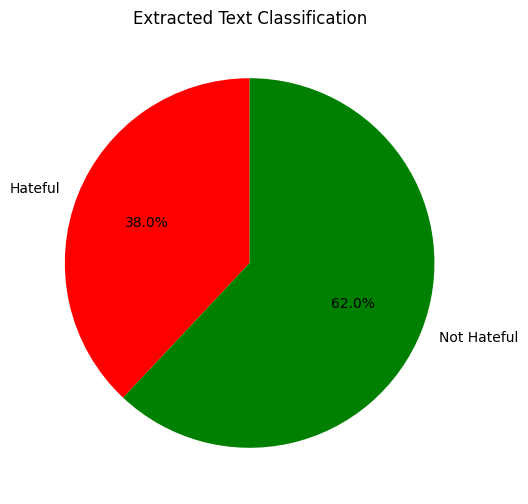

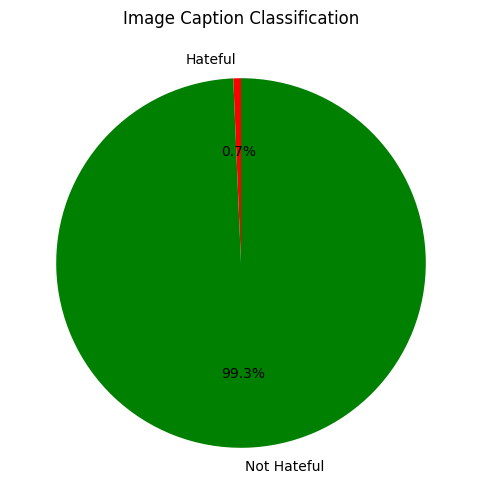

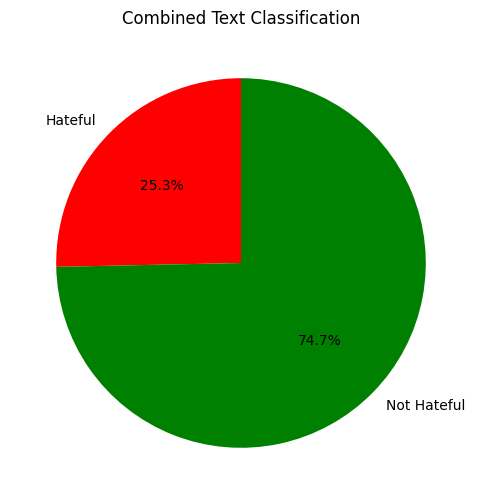

In [13]:
import matplotlib.pyplot as plt

# Path to the detection results file
file_path = 'C:/Users/sudee/OneDrive/Desktop/aa/Analyzing-Hateful-Memes/Bonus Task/detection_results.txt'

# Initialize a dictionary to store classification results for each category
classification_results = {'Extracted Text': [], 'Image Caption': [], 'Combined Text': []}

# Read the detection results file
with open(file_path, 'r') as file:
    lines = file.readlines()
    for i in range(1, len(lines), 5):  # Start from index 1 and step by 5
        if i + 4 > len(lines):  # Check if there are enough lines remaining
            break

        extracted_text_line, image_caption_line, combined_text_line = lines[i:i+3]

        # Check if extracted_text_line is not empty and contains ': '
        if extracted_text_line.strip() and ': ' in extracted_text_line:
            extracted_text_split = extracted_text_line.strip().split(': ')
            if len(extracted_text_split) > 1:
                extracted_text_class = extracted_text_split[1].split(',')[0]
            else:
                extracted_text_class = 'unknown'
        else:
            extracted_text_class = 'unknown'

        # Check if image_caption_line is not empty and contains ': '
        if image_caption_line.strip() and ': ' in image_caption_line:
            image_caption_split = image_caption_line.strip().split(': ')
            if len(image_caption_split) > 1:
                image_caption_class = image_caption_split[1].split(',')[0]
            else:
                image_caption_class = 'unknown'
        else:
            image_caption_class = 'unknown'

        # Check if combined_text_line is not empty and contains ': '
        if combined_text_line.strip() and ': ' in combined_text_line:
            combined_text_split = combined_text_line.strip().split(': ')
            if len(combined_text_split) > 1:
                combined_text_class = combined_text_split[1].split(',')[0]
            else:
                combined_text_class = 'unknown'
        else:
            combined_text_class = 'unknown'

        classification_results['Extracted Text'].append(extracted_text_class)
        classification_results['Image Caption'].append(image_caption_class)
        classification_results['Combined Text'].append(combined_text_class)

# Function to plot pie chart
def plot_pie_chart(classifications, title):
    labels = ['Hateful', 'Not Hateful']
    counts = [classifications.count('hateful'), classifications.count('not hateful')]
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['red', 'green'])
    plt.title(title)
    plt.show()

# Plotting
plot_pie_chart(classification_results['Extracted Text'], 'Extracted Text Classification')
plot_pie_chart(classification_results['Image Caption'], 'Image Caption Classification')
plot_pie_chart(classification_results['Combined Text'], 'Combined Text Classification')


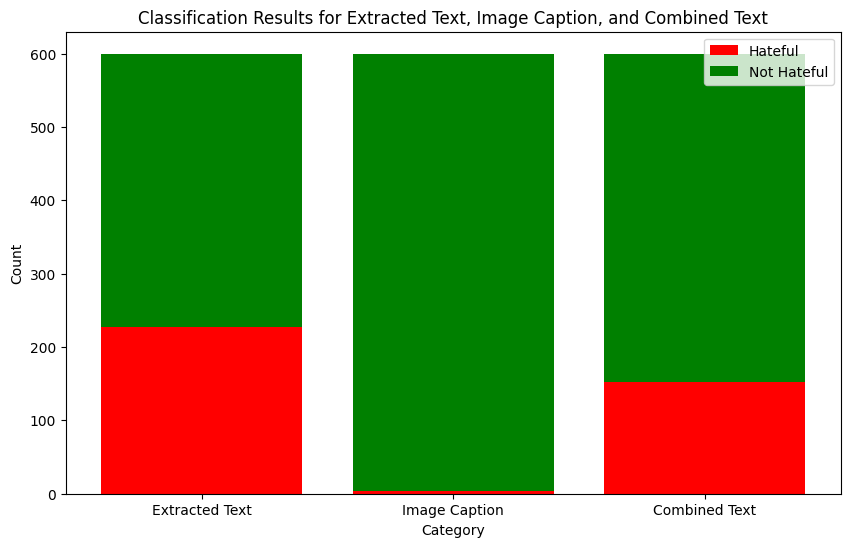

In [16]:
import matplotlib.pyplot as plt

# Path to the detection results file
file_path = 'C:/Users/sudee/OneDrive/Desktop/aa/Analyzing-Hateful-Memes/Bonus Task/detection_results.txt'
# Initialize a dictionary to store classification results for each category
classification_results = {'Extracted Text': [], 'Image Caption': [], 'Combined Text': []}

# Read the detection results file
with open(file_path, 'r') as file:
    lines = file.readlines()
    for i in range(1, len(lines), 5):  # Start from index 1 and step by 5
        if i + 4 > len(lines):  # Check if there are enough lines remaining
            break

        extracted_text_line, image_caption_line, combined_text_line = lines[i:i+3]

        # Check if extracted_text_line is not empty and contains ': '
        if extracted_text_line.strip() and ': ' in extracted_text_line:
            extracted_text_split = extracted_text_line.strip().split(': ')
            if len(extracted_text_split) > 1:
                extracted_text_class = extracted_text_split[1].split(',')[0]
            else:
                extracted_text_class = 'unknown'
        else:
            extracted_text_class = 'unknown'

        # Check if image_caption_line is not empty and contains ': '
        if image_caption_line.strip() and ': ' in image_caption_line:
            image_caption_split = image_caption_line.strip().split(': ')
            if len(image_caption_split) > 1:
                image_caption_class = image_caption_split[1].split(',')[0]
            else:
                image_caption_class = 'unknown'
        else:
            image_caption_class = 'unknown'

        # Check if combined_text_line is not empty and contains ': '
        if combined_text_line.strip() and ': ' in combined_text_line:
            combined_text_split = combined_text_line.strip().split(': ')
            if len(combined_text_split) > 1:
                combined_text_class = combined_text_split[1].split(',')[0]
            else:
                combined_text_class = 'unknown'
        else:
            combined_text_class = 'unknown'

        classification_results['Extracted Text'].append(extracted_text_class)
        classification_results['Image Caption'].append(image_caption_class)
        classification_results['Combined Text'].append(combined_text_class)

# Function to plot stacked bar chart
def plot_stacked_bar_chart(classification_results, title):
    labels = ['Extracted Text', 'Image Caption', 'Combined Text']
    hateful_counts = [classification_results[label].count('hateful') for label in labels]
    not_hateful_counts = [classification_results[label].count('not hateful') for label in labels]

    plt.figure(figsize=(10, 6))
    plt.bar(labels, hateful_counts, color='red', label='Hateful')
    plt.bar(labels, not_hateful_counts, bottom=hateful_counts, color='green', label='Not Hateful')

    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title(title)
    plt.legend()
    plt.show()

# Plotting
plot_stacked_bar_chart(classification_results, 'Classification Results for Extracted Text, Image Caption, and Combined Text')
